In [1]:
import pandas as pd
import os  
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import plotly as plt

In [2]:
main_df = pd.read_csv("/project/df_new_for_model.csv")
main_df.head()

,Unnamed: 0,Brief Name,Client,Shortlisted Agency,Agency Skills,Agency Industries,Project extension with same agency,Client selected agency themselves from marketplace,Right geography / time zone,Strong skill set match,...,Strong track record,Match Score,Brief Tags,AgencyLocations_Unknown,AgencyLocations_australia,AgencyLocations_united kingdom,AgencyLocations_united states,BriefRegion_australia,BriefRegion_united kingdom,BriefRegion_united states
0,0,awards applications x5,axa,boost awards,"copywriting , pr",professional services,0,0.0,1,1,...,1,0.418605,"pr , corporate comms",0,0,1,0,0,1,0
1,1,awards applications x5,axa,reed words,"brand strategy , copywriting , corporate commu...","administrative support services , alcoholic be...",0,0.0,1,1,...,1,0.418605,"pr , corporate comms",0,0,1,0,0,1,0
2,1,awards applications x5,axa,reed words,"brand strategy , copywriting , corporate commu...","administrative support services , alcoholic be...",0,0.0,1,1,...,1,0.418605,"pr , corporate comms",0,0,0,1,0,1,0
3,2,countrywide broker video,axa,viewpoint studios,"brand design , customer experience design , gr...","alcoholic beverages , automotive , beauty , co...",0,0.0,0,1,...,0,0.372093,videon production,0,0,1,0,0,1,0
4,3,countrywide broker video,axa,shoreditch design studio,"brand design , ux ui design , mobile app devel...",b2b,0,0.0,0,1,...,1,0.465116,videon production,0,1,0,0,0,1,0


In [3]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 23 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Unnamed: 0                                          335 non-null    int64  
 1   Brief Name                                          335 non-null    object 
 2   Client                                              335 non-null    object 
 3   Shortlisted Agency                                  335 non-null    object 
 4   Agency Skills                                       335 non-null    object 
 5   Agency Industries                                   335 non-null    object 
 6   Project extension with same agency                  335 non-null    int64  
 7   Client selected agency themselves from marketplace  335 non-null    float64
 8   Right geography / time zone                         335 non-null    int64  
 9  

In [4]:
import pandas as pd
from itertools import product

# Get unique brief names and agencies
brief_names = main_df['Brief Name'].unique()
agencies = main_df['Shortlisted Agency'].unique()

# Create all possible combinations of brief names and agencies
all_combinations = pd.DataFrame(product(brief_names, agencies), columns=['Brief Name', 'Shortlisted Agency'])

# Function to determine if the pair is a match
def is_match(row):
    return int(main_df[(main_df['Brief Name'] == row['Brief Name']) & (main_df['Shortlisted Agency'] == row['Shortlisted Agency'])].shape[0] > 0)

# Apply the function to the DataFrame
all_combinations['match'] = all_combinations.apply(is_match, axis=1)


In [5]:
all_combinations

,Brief Name,Shortlisted Agency,match
0,awards applications x5,boost awards,1
1,awards applications x5,reed words,1
2,awards applications x5,viewpoint studios,0
3,awards applications x5,shoreditch design studio,0
4,awards applications x5,blue feathers,0
...,...,...,...
12964,concept design,ellipsis,0
12965,concept design,wonderful,0
12966,concept design,verve,0
12967,concept design,flume,0


In [6]:
# Step 1: Merge on "Brief Name" and "Shortlisted Agency" to get agency information and reasons for matching
agency_location_columns = ['AgencyLocations_Unknown', 'AgencyLocations_australia', 'AgencyLocations_united kingdom', 'AgencyLocations_united states']

merged_df = all_combinations.merge(main_df[['Brief Name', 'Shortlisted Agency'] + agency_location_columns], on=['Brief Name', 'Shortlisted Agency'], how='left')

# Fill NaN values for unmatched rows with 0
merged_df[agency_location_columns] = merged_df[agency_location_columns].fillna(0)

# Step 2: Merge on "Brief Name" to get brief region features
brief_region_columns = ['BriefRegion_australia', 'BriefRegion_united kingdom', 'BriefRegion_united states']
brief_region_df = main_df[['Brief Name'] + brief_region_columns].drop_duplicates()
merged_df = merged_df.merge(brief_region_df, on='Brief Name', how='left')

# Fill NaN values for unmatched rows with 0 for brief region columns
merged_df[brief_region_columns] = merged_df[brief_region_columns].fillna(0)


In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13072 entries, 0 to 13071
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Brief Name                      13072 non-null  object 
 1   Shortlisted Agency              13072 non-null  object 
 2   match                           13072 non-null  int64  
 3   AgencyLocations_Unknown         13072 non-null  float64
 4   AgencyLocations_australia       13072 non-null  float64
 5   AgencyLocations_united kingdom  13072 non-null  float64
 6   AgencyLocations_united states   13072 non-null  float64
 7   BriefRegion_australia           13072 non-null  int64  
 8   BriefRegion_united kingdom      13072 non-null  int64  
 9   BriefRegion_united states       13072 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 1.1+ MB


In [ ]:
# # Convert "Brief Name" and "Agency" columns to lowercase
# brief_aug_loaded['Brief Name'] = brief_aug_loaded['Brief Name'].str.lower()
# agency_aug1_loaded['Agency'] = agency_aug1_loaded['Agency'].str.lower()
# main_df['Brief Name'] = main_df['Brief Name'].str.lower()
# main_df['Shortlisted Agency'] = main_df['Shortlisted Agency'].str.lower()

In [ ]:
# # Checking Agencies
# unique_agencies_main = set(main_df['Shortlisted Agency'].unique())
# unique_agencies_agency_aug1_loaded = set(agency_aug1_loaded['Agency'].unique())

# # Check if the sets are the same
# if unique_agencies_main == unique_agencies_agency_aug1_loaded:
#     print("Agencies match!")
# else:
#     print("Agencies do not match!")
#     print("In main_df but not in agency_aug1_loaded:", unique_agencies_main - unique_agencies_agency_aug1_loaded)
#     print("In agency_aug1_loaded but not in main_df:", unique_agencies_agency_aug1_loaded - unique_agencies_main)

# # Checking Brief Names (replace 'Some_Column' with the actual column name)
# unique_briefs_main = set(main_df['Brief Name'].unique())
# unique_briefs_brief_aug_loaded = set(brief_aug_loaded['Brief Name'].unique())

# # Check if the sets are the same
# if unique_briefs_main == unique_briefs_brief_aug_loaded:
#     print("Brief names match!")
# else:
#     print("Brief names do not match!")
#     print("In main_df but not in brief_aug_loaded:", unique_briefs_main - unique_briefs_brief_aug_loaded)
#     print("In brief_aug_loaded but not in main_df:", unique_briefs_brief_aug_loaded - unique_briefs_main)


In [ ]:
# # Function to normalize names
# def normalize_name(name):
#     return name.strip().lower().replace('  ', ' ')

# # Apply normalization to both dataframes
# main_df['Shortlisted Agency'] = main_df['Shortlisted Agency'].apply(normalize_name)
# agency_aug1_loaded['Agency'] = agency_aug1_loaded['Agency'].apply(normalize_name)

# # Find mismatches
# missing_in_main = set(agency_aug1_loaded['Agency']) - set(main_df['Shortlisted Agency'])
# missing_in_agency = set(main_df['Shortlisted Agency']) - set(agency_aug1_loaded['Agency'])

# # Print examples of mismatches
# print("Missing in main_df:", list(missing_in_main)[:5])
# print("Missing in agency_aug1_loaded:", list(missing_in_agency)[:5])


In [ ]:
# # Get unique agency names from both dataframes
# unique_agencies_main = sorted(main_df['Shortlisted Agency'].unique())
# unique_agencies_agency_aug1_loaded = sorted(agency_aug1_loaded['Agency'].unique())

# # Print or return the names
# print("Unique agencies in main_df:")
# print(unique_agencies_main)

# print("\nUnique agencies in agency_aug1_loaded:")
# print(unique_agencies_agency_aug1_loaded)


In [ ]:
# def normalize_agency_name(name):
#     name = name.lower()                # Convert to lowercase
#     name = name.replace('&', 'and')    # Replace ampersands
#     name = name.replace('.', '')       # Remove periods
#     name = name.strip()                # Remove leading and trailing whitespace
#     return name

# # Apply the normalization to both lists
# main_df['Shortlisted Agency'] = main_df['Shortlisted Agency'].apply(normalize_agency_name)
# agency_aug1_loaded['Agency'] = agency_aug1_loaded['Agency'].apply(normalize_agency_name)


In [ ]:
# # Find mismatches
# missing_in_main = set(agency_aug1_loaded['Agency']) - set(main_df['Shortlisted Agency'])
# missing_in_agency = set(main_df['Shortlisted Agency']) - set(agency_aug1_loaded['Agency'])

# print("Missing in main_df:", missing_in_main)
# print("Missing in agency_aug1_loaded:", missing_in_agency)


In [ ]:
# # Extract unique brief names from main_df
# unique_briefs_main_df = set(main_df['Brief Name'].str.lower().str.strip())

# # Print or return the list
# print("Unique brief names in main_df:")
# print(sorted(list(unique_briefs_main_df)))
# # Extract unique brief names from brief_aug_loaded
# unique_briefs_brief_aug_loaded = set(brief_aug_loaded['Brief Name'].str.lower().str.strip())

# # Print or return the list
# print("Unique brief names in brief_aug_loaded:")
# print(sorted(list(unique_briefs_brief_aug_loaded)))


In [ ]:
# # Find mismatches
# missing_in_main = unique_briefs_brief_aug_loaded - unique_briefs_main_df
# missing_in_brief_aug = unique_briefs_main_df - unique_briefs_brief_aug_loaded

# print("Missing in main_df:", sorted(list(missing_in_main)))
# print("Missing in brief_aug_loaded:", sorted(list(missing_in_brief_aug)))


In [ ]:
# def normalize_text(text):
#     return text.str.lower().str.strip().str.replace('&', 'and')

# main_df['Brief Name'] = normalize_text(main_df['Brief Name'])

# brief_aug_loaded['Brief Name'] = normalize_text(brief_aug_loaded['Brief Name'])

In [ ]:
# # Find mismatches
# missing_in_main = unique_briefs_brief_aug_loaded - unique_briefs_main_df
# missing_in_brief_aug = unique_briefs_main_df - unique_briefs_brief_aug_loaded

# print("Missing in main_df:", sorted(list(missing_in_main)))
# print("Missing in brief_aug_loaded:", sorted(list(missing_in_brief_aug)))


In [ ]:
# # Merge the brief and main dataframes on the 'Brief Name' column
# merged_brief_main = pd.merge(brief_aug_loaded, main_df, left_on='Brief Name', right_on='Brief Name', how='left')

# # Merge the resulting dataframe with the agency dataframe using the 'Shortlisted Agency' column
# final_merged = pd.merge(merged_brief_main, agency_aug1_loaded, left_on='Shortlisted Agency', right_on='Agency', how='left')

# # You can now print or manipulate the final merged DataFrame
# print(final_merged.head())


In [ ]:
# # Step 1: Create all possible pairings of unique agencies and brief names
# import itertools

# unique_agencies = agency_aug1_loaded['Agency'].unique()
# unique_brief_names = brief_aug_loaded['Brief Name'].unique()

# all_pairings = pd.DataFrame(list(itertools.product(unique_agencies, unique_brief_names)), columns=['Agency', 'Brief Name'])

# # Step 2: Merge the all_pairings DataFrame with the final_merged DataFrame
# paired_data = pd.merge(all_pairings, final_merged, on=['Agency', 'Brief Name'], how='left')

# # Step 3: Create the "match" column
# paired_data['match'] = paired_data['Shortlisted Agency'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [ ]:
# # Merge main_df with agency_aug1_loaded on "Shortlisted Agency"
# merged_agency_data = main_df.merge(agency_aug1_loaded, left_on='Shortlisted Agency', right_on='Agency', how='inner')
# merged_agency_data

In [ ]:
# # Merge merged_agency_data with brief_aug_loaded on "Brief Name"
# final_merged_data = merged_agency_data.merge(brief_aug_loaded, on='Brief Name', how='inner', suffixes=('_agency', '_brief'))
# final_merged_data

In [ ]:
# final_merged_data['match'] = 0
# final_merged_data.loc[final_merged_data['Shortlisted Agency'] == final_merged_data['Agency'],
#                       'match'] = 1


In [ ]:
# final_merged_data.info()

In [18]:
# import pandas as pd

# # Assuming you have a DataFrame named 'final_merged_data' with the existing data

# # Creating a DataFrame with all possible agency and brief name combinations
# agencies = final_merged_data['Agency'].unique()
# brief_names = final_merged_data['Brief Name'].unique()
# all_combinations = [(brief, agency) for brief in brief_names for agency in agencies]
# expanded_final_merged_data = pd.DataFrame(all_combinations, columns=['Brief Name', 'Agency'])

# # Merging with the original DataFrame to get the shortlisted agency for each brief
# merged_final_merged_data = expanded_final_merged_data.merge(final_merged_data[['Brief Name', 'Shortlisted Agency']], on='Brief Name', how='left')

# # Creating the target variable by comparing the agency with the shortlisted agency
# merged_final_merged_data['match'] = (merged_final_merged_data['Agency'] == merged_final_merged_data['Shortlisted Agency']).astype(int)

# # Now 'merged_final_merged_data' contains the expanded dataset with the new 'match' column


In [35]:
# final_merged_data.info()

In [36]:
# merged_final_merged_data

In [37]:
# # Merging with brief_aug_loaded using 'Brief Name' as the key
# merged_with_brief = pd.merge(merged_df[['Brief Name']], brief_aug_loaded[['Brief Name', 'embedding']], on='Brief Name', how='left')

# # Renaming the columns for better clarity
# merged_with_brief.rename(columns={'embedding': 'embedding_brief'}, inplace=True)

# # Merging with agency_aug1_loaded using 'Agency' and 'Shortlisted Agency' as the keys
# final_df = pd.merge(merged_df[['Brief Name', 'Shortlisted Agency']], agency_aug1_loaded[['Agency', 'embedding']], left_on='Shortlisted Agency', right_on='Agency', how='left')

# # Renaming the columns for better clarity
# final_df.rename(columns={'embedding': 'embedding_agency'}, inplace=True)

# # Now final_df contains the desired columns
# final_df

In [38]:
# final_df.info()

In [16]:
# from keras.models import Model
# from keras.layers import Input, Dense

# # Define the neural network model
# input_layer = Input(shape=(X_train.shape[1],))
# hidden_layer_1 = Dense(128, activation='relu')(input_layer)
# hidden_layer_2 = Dense(64, activation='relu')(hidden_layer_1)
# output_layer = Dense(1, activation='sigmoid')(hidden_layer_2)

# model = Model(inputs=input_layer, outputs=output_layer)

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [8]:
df = merged_df.copy()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13072 entries, 0 to 13071
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Brief Name                      13072 non-null  object 
 1   Shortlisted Agency              13072 non-null  object 
 2   match                           13072 non-null  int64  
 3   AgencyLocations_Unknown         13072 non-null  float64
 4   AgencyLocations_australia       13072 non-null  float64
 5   AgencyLocations_united kingdom  13072 non-null  float64
 6   AgencyLocations_united states   13072 non-null  float64
 7   BriefRegion_australia           13072 non-null  int64  
 8   BriefRegion_united kingdom      13072 non-null  int64  
 9   BriefRegion_united states       13072 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 1.1+ MB


In [10]:
df['match'].value_counts()

0    12737
1      335
Name: match, dtype: int64

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming the dataframe is named df
X = df.drop(columns=['Brief Name', 'Shortlisted Agency', 'match'])
y = df['match']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Neural Network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')




2023-08-14 18:18:20.568687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda/envs/Python3/lib:
2023-08-14 18:18:20.568722: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-14 18:18:21.858998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda/envs/Python3/lib:
2023-08-14 18:18:21.859033: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-14 18:18:21.859057: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cube-47f2ef94-d182-448

Epoch 1/10
295/295 [==============================] - 1s 2ms/step - loss: 0.1358 - accuracy: 0.9776 - val_loss: 0.0227 - val_accuracy: 0.9990
Epoch 2/10
295/295 [==============================] - 0s 1ms/step - loss: 0.0071 - accuracy: 0.9991 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 3/10
295/295 [==============================] - 0s 1ms/step - loss: 9.2283e-04 - accuracy: 1.0000 - val_loss: 4.8658e-04 - val_accuracy: 1.0000
Epoch 4/10
295/295 [==============================] - 0s 1ms/step - loss: 3.2883e-04 - accuracy: 1.0000 - val_loss: 2.2339e-04 - val_accuracy: 1.0000
Epoch 5/10
295/295 [==============================] - 0s 1ms/step - loss: 1.6657e-04 - accuracy: 1.0000 - val_loss: 1.2603e-04 - val_accuracy: 1.0000
Epoch 6/10
295/295 [==============================] - 0s 1ms/step - loss: 9.9170e-05 - accuracy: 1.0000 - val_loss: 7.9385e-05 - val_accuracy: 1.0000
Epoch 7/10
295/295 [==============================] - 0s 1ms/step - loss: 6.4604e-05 - accuracy: 1.0000 - val_loss: 

NameError: name 'classification_report' is not defined

In [45]:
X_train

,Right geography / time zone,Strong skill set match,Deep / relevant sector expertise,Good cultural fit,Right price level,Strong track record,Project extension with same agency,Client selected agency themselves from marketplace,AgencyLocations_Unknown,AgencyLocations_australia,AgencyLocations_united kingdom,AgencyLocations_united states,BriefRegion_australia,BriefRegion_united kingdom,BriefRegion_united states
2629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
8898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
4953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
5324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
10217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
5191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
5390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0


In [46]:
# Training the model and capturing the history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Extracting loss and accuracy from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


Epoch 1/10
143/295 [=============>................] - ETA: 0s - loss: 1.2281e-05 - accuracy: 1.0000

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/keras/engine/data_adapter.py:1510: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


295/295 [==============================] - 0s 1ms/step - loss: 1.0145e-05 - accuracy: 1.0000 - val_loss: 7.5615e-06 - val_accuracy: 1.0000
Epoch 2/10
295/295 [==============================] - 0s 1ms/step - loss: 7.8012e-06 - accuracy: 1.0000 - val_loss: 5.9178e-06 - val_accuracy: 1.0000
Epoch 3/10
295/295 [==============================] - 0s 1ms/step - loss: 6.0802e-06 - accuracy: 1.0000 - val_loss: 4.6683e-06 - val_accuracy: 1.0000
Epoch 4/10
295/295 [==============================] - 0s 1ms/step - loss: 4.7984e-06 - accuracy: 1.0000 - val_loss: 3.7275e-06 - val_accuracy: 1.0000
Epoch 5/10
295/295 [==============================] - 0s 1ms/step - loss: 3.8214e-06 - accuracy: 1.0000 - val_loss: 3.0088e-06 - val_accuracy: 1.0000
Epoch 6/10
295/295 [==============================] - 0s 1ms/step - loss: 3.0621e-06 - accuracy: 1.0000 - val_loss: 2.4325e-06 - val_accuracy: 1.0000
Epoch 7/10
295/295 [==============================] - 0s 1ms/step - loss: 2.4629e-06 - accuracy: 1.0000 - val_l

Epoch 1/10
327/327 [==============================] - 1s 2ms/step - loss: 4.8983e-06 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 2/10
327/327 [==============================] - 1s 2ms/step - loss: 3.9269e-06 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 3/10
327/327 [==============================] - 1s 2ms/step - loss: 3.3882e-06 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 4/10
327/327 [==============================] - 1s 2ms/step - loss: 2.9434e-06 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 5/10
327/327 [==============================] - 1s 2ms/step - loss: 2.3275e-06 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 6/10
327/327 [==============================] - 1s 2ms/step - loss: 1.8907e-06 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 7/10
327/327 [==============================] - 1s 2ms/step - loss: 1.6418e-06 - accuracy: 1.0000 - val_loss: 0.0020 -

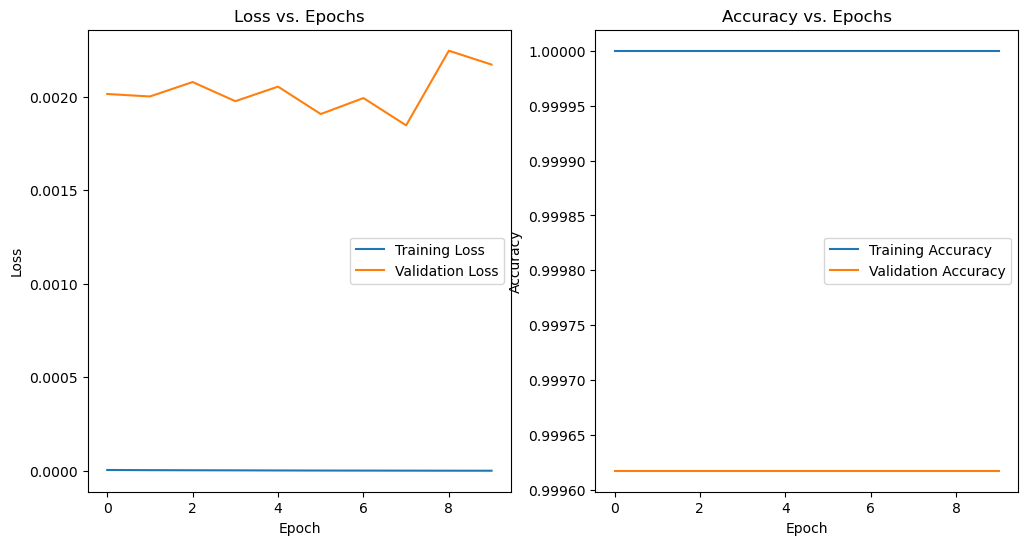

In [41]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [40]:
from sklearn.metrics import classification_report

# Predict classes on validation data
y_val_pred = model.predict(X_val)
y_val_pred_classes = (y_val_pred > 0.5).astype('int32')

# Print classification report
report = classification_report(y_val, y_val_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2550
           1       1.00      0.98      0.99        65

    accuracy                           1.00      2615
   macro avg       1.00      0.99      1.00      2615
weighted avg       1.00      1.00      1.00      2615



In [ ]:
# model with ooversampling of the minority class using SMOTE

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample

# Define X and y
X = df.drop(columns=['Brief Name', 'Shortlisted Agency', 'match'])
y = df['match']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate the majority and minority classes in training data
X_train_majority = X_train[y_train == 0]
X_train_minority = X_train[y_train == 1]

# Upsample the minority class in training data
X_train_minority_upsampled = resample(X_train_minority, 
                                      replace=True,     # Sample with replacement
                                      n_samples=len(X_train_majority),    # Match number in majority class
                                      random_state=42)  # Reproducible results

# Combine the majority class with the upsampled minority class
X_train_upsampled = pd.concat([X_train_majority, X_train_minority_upsampled])
y_train_upsampled = pd.concat([y_train[y_train == 0], pd.Series([1] * len(X_train_minority_upsampled), index=X_train_minority_upsampled.index)])

# New class counts
print(y_train_upsampled.value_counts())

# Creating the Neural Network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_upsampled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Using early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model with validation split
model.fit(X_train_upsampled, y_train_upsampled, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Additional metrics
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_classes))


0    10187
1    10187
dtype: int64
Epoch 1/100


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/keras/engine/data_adapter.py:1510: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


573/573 [==============================] - 1s 1ms/step - loss: 0.0891 - accuracy: 0.9915 - val_loss: 7.5280e-04 - val_accuracy: 1.0000
Epoch 2/100
573/573 [==============================] - 1s 1ms/step - loss: 4.3214e-04 - accuracy: 1.0000 - val_loss: 1.3345e-04 - val_accuracy: 1.0000
Epoch 3/100
573/573 [==============================] - 1s 1ms/step - loss: 1.0131e-04 - accuracy: 1.0000 - val_loss: 4.9141e-05 - val_accuracy: 1.0000
Epoch 4/100
573/573 [==============================] - 1s 1ms/step - loss: 4.2566e-05 - accuracy: 1.0000 - val_loss: 2.4206e-05 - val_accuracy: 1.0000
Epoch 5/100
573/573 [==============================] - 1s 1ms/step - loss: 2.1615e-05 - accuracy: 1.0000 - val_loss: 1.3595e-05 - val_accuracy: 1.0000
Epoch 6/100
573/573 [==============================] - 1s 1ms/step - loss: 1.2455e-05 - accuracy: 1.0000 - val_loss: 8.1509e-06 - val_accuracy: 1.0000
Epoch 7/100
573/573 [==============================] - 1s 1ms/step - loss: 7.6800e-06 - accuracy: 1.0000 - val

In [22]:
!pip install fuzzywuzzy

/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by bash)
  Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl (18 kB)


In [25]:
from fuzzywuzzy import process

def get_agency_embedding(agency_name):
    best_match = process.extractOne(agency_name, agency_aug1_loaded['Agency'])
    return agency_aug1_loaded.loc[agency_aug1_loaded['Agency'] == best_match[0], 'embedding'].iloc[0]

def get_brief_embedding(brief_name):
    best_match = process.extractOne(brief_name, brief_aug_loaded['Brief Name'])[0]
    return brief_aug_loaded.loc[brief_aug_loaded['Brief Name'] == best_match, 'embedding'].iloc[0]


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [26]:
df['AgencyEmbedding'] = df['Shortlisted Agency'].apply(get_agency_embedding)
df['BriefEmbedding'] = df['Brief Name'].apply(get_brief_embedding)
df

,Brief Name,Shortlisted Agency,match,AgencyLocations_Unknown,AgencyLocations_australia,AgencyLocations_united kingdom,AgencyLocations_united states,BriefRegion_australia,BriefRegion_united kingdom,BriefRegion_united states,AgencyEmbedding,BriefEmbedding
0,awards applications x5,boost awards,1,0.0,0.0,1.0,0.0,0,1,0,"[-0.07117718, 0.12976368, 0.6437149, -0.032220...","[-0.07292219, 0.24209613, 0.48748997, -0.16100..."
1,awards applications x5,reed words,1,0.0,0.0,1.0,0.0,0,1,0,"[-0.04470034, 0.12006818, 0.55236816, 0.008697...","[-0.07292219, 0.24209613, 0.48748997, -0.16100..."
2,awards applications x5,reed words,1,0.0,0.0,0.0,1.0,0,1,0,"[-0.04470034, 0.12006818, 0.55236816, 0.008697...","[-0.07292219, 0.24209613, 0.48748997, -0.16100..."
3,awards applications x5,viewpoint studios,0,0.0,0.0,0.0,0.0,0,1,0,"[-0.10483225, 0.13232909, 0.5668494, 0.0788079...","[-0.07292219, 0.24209613, 0.48748997, -0.16100..."
4,awards applications x5,shoreditch design studio,0,0.0,0.0,0.0,0.0,0,1,0,"[0.084042266, 0.069853276, 0.6240732, -0.06212...","[-0.07292219, 0.24209613, 0.48748997, -0.16100..."
...,...,...,...,...,...,...,...,...,...,...,...,...
13067,concept design,ellipsis,0,0.0,0.0,0.0,0.0,0,1,0,"[-0.042306833, 0.03438079, 0.62003714, 0.03337...","[0.005172481, 0.2599711, 0.49758333, -0.117984..."
13068,concept design,wonderful,0,0.0,0.0,0.0,0.0,0,1,0,"[-0.094590604, -0.023357961, 0.52706045, 0.091...","[0.005172481, 0.2599711, 0.49758333, -0.117984..."
13069,concept design,verve,0,0.0,0.0,0.0,0.0,0,1,0,"[-0.20032367, 0.027215479, 0.5465713, 0.044908...","[0.005172481, 0.2599711, 0.49758333, -0.117984..."
13070,concept design,flume,0,0.0,0.0,0.0,0.0,0,1,0,"[-0.08368838, 0.046109892, 0.52297544, 0.00558...","[0.005172481, 0.2599711, 0.49758333, -0.117984..."


In [28]:
df1 = df.copy()

In [11]:
# saving the file so wont have to run again
df1.to_csv("df1.csv")

NameError: name 'df1' is not defined

In [ ]:
# model with all features (including embeddings)

In [42]:
# Concatenate the numerical features
numerical_features = [
#     'Right geography / time zone',
#     'Strong skill set match',
#     'Deep / relevant sector expertise',
#     'Good cultural fit',
#     'Right price level',
#     'Strong track record',
#     'Project extension with same agency',
#     'Client selected agency themselves from marketplace',
    'AgencyLocations_Unknown',
    'AgencyLocations_australia',
    'AgencyLocations_united kingdom',
    'AgencyLocations_united states',
    'BriefRegion_australia',
    'BriefRegion_united kingdom',
    'BriefRegion_united states'
]

# Concatenate embeddings with numerical features
X = np.hstack((df1[numerical_features].values,
               np.stack(df1['AgencyEmbedding']),
               np.stack(df1['BriefEmbedding'])))

# Target variable
y = df1['match'].values
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, input_dim=X.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Sigmoid for binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
327/327 [==============================] - 1s 2ms/step - loss: 0.1213 - accuracy: 0.9742 - val_loss: 0.1046 - val_accuracy: 0.9751
Epoch 2/10
327/327 [==============================] - 1s 2ms/step - loss: 0.1012 - accuracy: 0.9744 - val_loss: 0.0824 - val_accuracy: 0.9751
Epoch 3/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0544 - accuracy: 0.9859 - val_loss: 0.0288 - val_accuracy: 0.9924
Epoch 4/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0198 - accuracy: 0.9947 - val_loss: 0.0199 - val_accuracy: 0.9943
Epoch 5/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0456 - accuracy: 0.9910 - val_loss: 0.0287 - val_accuracy: 0.9931
Epoch 6/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0026 - val_accuracy: 0.9996
Epoch 7/10
327/327 [==============================] - 1s 2ms/step - loss: 1.3183e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9996
Ep

In [44]:
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))
print("Validation Loss: {:.4f}".format(loss))


82/82 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.9996
Validation Accuracy: 99.96%
Validation Loss: 0.0025


Epoch 1/10
327/327 [==============================] - 1s 2ms/step - loss: 1.2864e-05 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9996
Epoch 2/10
327/327 [==============================] - 1s 2ms/step - loss: 9.5216e-06 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 0.9996
Epoch 3/10
327/327 [==============================] - 1s 2ms/step - loss: 7.4589e-06 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9996
Epoch 4/10
327/327 [==============================] - 1s 2ms/step - loss: 5.7841e-06 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 0.9996
Epoch 5/10
327/327 [==============================] - 1s 2ms/step - loss: 4.7621e-06 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9996
Epoch 6/10
327/327 [==============================] - 1s 2ms/step - loss: 3.7516e-06 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9996
Epoch 7/10
327/327 [==============================] - 1s 2ms/step - loss: 3.0308e-06 - accuracy: 1.0000 - val_loss: 0.0026 -

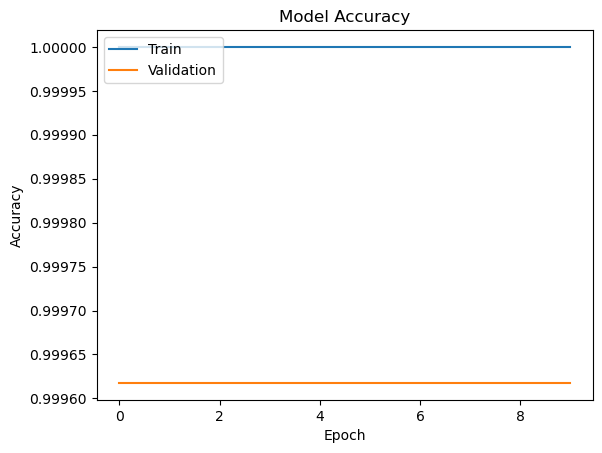

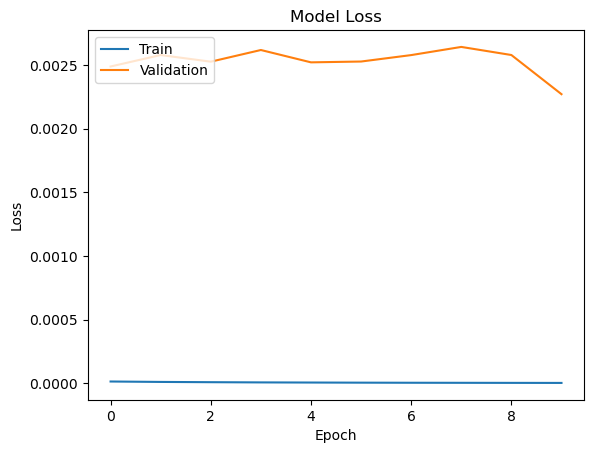

In [45]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Plotting Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [46]:
# Select a random brief from the test set
random_idx = np.random.choice(X_val.shape[0])
selected_brief = X_val[random_idx]
# For simplicity, we'll use the entire dataset (X) to get agency data 
# and pair it with the selected brief

# Extract agency-related data columns from our dataset
agency_data = X[:, len(numerical_features):]

# Create a dataset with the selected brief and each agency
recommendation_data = np.hstack([np.tile(selected_brief[:len(numerical_features)], (agency_data.shape[0], 1)), 
                                 agency_data])


In [51]:
# Predict the match probabilities for each agency-brief pair
predicted_probs = model.predict(recommendation_data)
# Rank the agencies based on the predicted probabilities
sorted_indices = np.argsort(-predicted_probs[:, 0]) # The negative sign is for descending order
recommended_agencies = df['Shortlisted Agency'].iloc[sorted_indices].values


In [57]:
print(recommended_agencies[:10])


['xdesign' 'xdesign' 'xdesign' 'path ventures' 'shoreditch design studio'
 'shoreditch design studio' 'shoreditch design studio' 'launch studio'
 'path ventures' 'launch studio']


In [45]:
# approach

In [56]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming data is your DataFrame containing the data
selected_columns = [
    'Right geography / time zone', 'Strong skill set match', 'Deep / relevant sector expertise',
    'Good cultural fit', 'Right price level', 'Strong track record', 'Project extension with same agency',
    'Client selected agency themselves from marketplace', 'AgencyLocations_Unknown', 'AgencyLocations_australia',
    'AgencyLocations_united kingdom', 'AgencyLocations_united states', 'BriefRegion_australia',
    'BriefRegion_united kingdom', 'BriefRegion_united states'
]

# Convert embeddings to numpy arrays if needed
# Assuming the embeddings are stored as lists or arrays within the DataFrame
data['AgencyEmbedding'] = data['AgencyEmbedding'].apply(np.array)
data['BriefEmbedding'] = data['BriefEmbedding'].apply(np.array)

# Combine features
X = data.apply(lambda row: np.concatenate([
    row['AgencyEmbedding'],
    row['BriefEmbedding'],
    [row[col] for col in selected_columns]
]), axis=1)

y = data['match']

# Convert to numpy arrays
X = np.stack(X)
y = y.values

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [81]:
df.head()

,Brief Name,Shortlisted Agency,match,Right geography / time zone,Strong skill set match,Deep / relevant sector expertise,Good cultural fit,Right price level,Strong track record,Project extension with same agency,Client selected agency themselves from marketplace,AgencyLocations_Unknown,AgencyLocations_australia,AgencyLocations_united kingdom,AgencyLocations_united states,BriefRegion_australia,BriefRegion_united kingdom,BriefRegion_united states,AgencyEmbedding,BriefEmbedding
0,awards applications x5,boost awards,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,"[-0.07117718, 0.12976368, 0.6437149, -0.032220...","[-0.07292219, 0.24209613, 0.48748997, -0.16100..."
1,awards applications x5,reed words,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,"[-0.04470034, 0.12006818, 0.55236816, 0.008697...","[-0.07292219, 0.24209613, 0.48748997, -0.16100..."
2,awards applications x5,reed words,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,"[-0.04470034, 0.12006818, 0.55236816, 0.008697...","[-0.07292219, 0.24209613, 0.48748997, -0.16100..."
3,awards applications x5,viewpoint studios,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,"[-0.10483225, 0.13232909, 0.5668494, 0.0788079...","[-0.07292219, 0.24209613, 0.48748997, -0.16100..."
4,awards applications x5,shoreditch design studio,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,"[0.084042266, 0.069853276, 0.6240732, -0.06212...","[-0.07292219, 0.24209613, 0.48748997, -0.16100..."


In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming you've loaded the DataFrame as df1
# df1['AgencyEmbedding'] = df1['AgencyEmbedding'].apply(eval)
# df1['BriefEmbedding'] = df1['BriefEmbedding'].apply(eval)

# Splitting the embeddings into separate columns
agency_embedding_df1 = pd.DataFrame(df1['AgencyEmbedding'].tolist())
brief_embedding_df1 = pd.DataFrame(df1['BriefEmbedding'].tolist())

# Concatenating them with the main DataFrame
df1 = pd.concat([df1, agency_embedding_df1, brief_embedding_df1], axis=1)
df1.drop(['AgencyEmbedding', 'BriefEmbedding'], axis=1, inplace=True)

#  drop 'Brief Name' and 'Shortlisted Agency' 
df1.drop(['Brief Name', 'Shortlisted Agency'], axis=1, inplace=True)
# Separating the target and features
X = df1.drop('match', axis=1)
y = df1['match']

from sklearn.model_selection import train_test_split

# Splitting into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# Normalizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
from keras.models import Sequential
from keras.layers import Dense

# Defining the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
# Evaluating the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

# Making predictions (replace new_data with your actual new data)
new_data_scaled = scaler.transform(new_data) # Make sure to preprocess new_data similarly
predictions = model.predict(new_data_scaled)


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Epoch 1/10
327/327 [==============================] - 1s 2ms/step - loss: 0.1080 - accuracy: 0.9723 - val_loss: 0.0780 - val_accuracy: 0.9778
Epoch 2/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0399 - accuracy: 0.9864 - val_loss: 0.0201 - val_accuracy: 0.9943
Epoch 3/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.0073 - val_accuracy: 0.9973
Epoch 4/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0042 - val_accuracy: 0.9992
Epoch 5/10
327/327 [==============================] - 1s 2ms/step - loss: 4.0926e-04 - accuracy: 0.9998 - val_loss: 0.0063 - val_accuracy: 0.9977
Epoch 6/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.0042 - val_accuracy: 0.9992
Epoch 7/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0306 - accuracy: 0.9934 - val_loss: 0.0304 - val_accuracy: 0.9916
Ep

NameError: name 'new_data' is not defined

In [12]:
df1 = pd.read_csv("/project/df1.csv")
df1

,Unnamed: 0,Brief Name,Shortlisted Agency,match,AgencyLocations_Unknown,AgencyLocations_australia,AgencyLocations_united kingdom,AgencyLocations_united states,BriefRegion_australia,BriefRegion_united kingdom,BriefRegion_united states,AgencyEmbedding,BriefEmbedding
0,0,awards applications x5,boost awards,1,0.0,0.0,1.0,0.0,0,1,0,[-7.11771771e-02 1.29763678e-01 6.43714905e-...,[-7.29221925e-02 2.42096126e-01 4.87489969e-...
1,1,awards applications x5,reed words,1,0.0,0.0,1.0,0.0,0,1,0,[-4.47003394e-02 1.20068178e-01 5.52368164e-...,[-7.29221925e-02 2.42096126e-01 4.87489969e-...
2,2,awards applications x5,reed words,1,0.0,0.0,0.0,1.0,0,1,0,[-4.47003394e-02 1.20068178e-01 5.52368164e-...,[-7.29221925e-02 2.42096126e-01 4.87489969e-...
3,3,awards applications x5,viewpoint studios,0,0.0,0.0,0.0,0.0,0,1,0,[-1.04832247e-01 1.32329091e-01 5.66849411e-...,[-7.29221925e-02 2.42096126e-01 4.87489969e-...
4,4,awards applications x5,shoreditch design studio,0,0.0,0.0,0.0,0.0,0,1,0,[ 8.40422660e-02 6.98532760e-02 6.24073207e-...,[-7.29221925e-02 2.42096126e-01 4.87489969e-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13067,13067,concept design,ellipsis,0,0.0,0.0,0.0,0.0,0,1,0,[-4.23068330e-02 3.43807898e-02 6.20037138e-...,[ 5.17248083e-03 2.59971112e-01 4.97583330e-...
13068,13068,concept design,wonderful,0,0.0,0.0,0.0,0.0,0,1,0,[-9.45906043e-02 -2.33579613e-02 5.27060449e-...,[ 5.17248083e-03 2.59971112e-01 4.97583330e-...
13069,13069,concept design,verve,0,0.0,0.0,0.0,0.0,0,1,0,[-2.00323671e-01 2.72154789e-02 5.46571314e-...,[ 5.17248083e-03 2.59971112e-01 4.97583330e-...
13070,13070,concept design,flume,0,0.0,0.0,0.0,0.0,0,1,0,[-8.36883783e-02 4.61098924e-02 5.22975445e-...,[ 5.17248083e-03 2.59971112e-01 4.97583330e-...


In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13072 entries, 0 to 13071
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      13072 non-null  int64  
 1   Brief Name                      13072 non-null  object 
 2   Shortlisted Agency              13072 non-null  object 
 3   match                           13072 non-null  int64  
 4   AgencyLocations_Unknown         13072 non-null  float64
 5   AgencyLocations_australia       13072 non-null  float64
 6   AgencyLocations_united kingdom  13072 non-null  float64
 7   AgencyLocations_united states   13072 non-null  float64
 8   BriefRegion_australia           13072 non-null  int64  
 9   BriefRegion_united kingdom      13072 non-null  int64  
 10  BriefRegion_united states       13072 non-null  int64  
 11  AgencyEmbedding                 13072 non-null  object 
 12  BriefEmbedding                  

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

# Drop the 'Unnamed: 0' column
# df1.drop('Unnamed: 0', axis=1, inplace=True)

# Convert the 'AgencyEmbedding' and 'BriefEmbedding' columns from string to lists
# Convert space-separated strings to lists of floats
agency_embedding_df1 = df1['AgencyEmbedding'].str.split().apply(lambda x: [float(i) for i in x])
brief_embedding_df1 = df1['BriefEmbedding'].str.split().apply(lambda x: [float(i) for i in x])

# Convert lists of floats to DataFrames
agency_embedding_df1 = pd.DataFrame(agency_embedding_df1.tolist())
brief_embedding_df1 = pd.DataFrame(brief_embedding_df1.tolist())

# Concatenate them with the main DataFrame
df1 = pd.concat([df1, agency_embedding_df1, brief_embedding_df1], axis=1)
df1.drop(['AgencyEmbedding', 'BriefEmbedding'], axis=1, inplace=True)

# Drop unnecessary columns
df1.drop(['Brief Name', 'Shortlisted Agency'], axis=1, inplace=True)

# Separate target and features
X = df1.drop('match', axis=1)
y = df1['match']

# Splitting into training, validation, and test sets with stratification
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Normalizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Defining the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluating the model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Evaluating the model on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Making predictions on the test set
test_predictions = model.predict(X_test)


ValueError: could not convert string to float: '[-7.11771771e-02'

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import ast

# Drop the unnecessary 'Unnamed: 0' column
df1.drop(['Unnamed: 0'], axis=1, inplace=True)

# # Assuming the embeddings are strings of lists, convert them to lists
# df1['AgencyEmbedding'] = df1['AgencyEmbedding'].apply(ast.literal_eval)
# df1['BriefEmbedding'] = df1['BriefEmbedding'].apply(ast.literal_eval)

# Splitting the embeddings into separate columns
agency_embedding_df1 = pd.DataFrame(df1['AgencyEmbedding'].tolist())
brief_embedding_df1 = pd.DataFrame(df1['BriefEmbedding'].tolist())

# Concatenating them with the main DataFrame
df1 = pd.concat([df1, agency_embedding_df1, brief_embedding_df1], axis=1)
df1.drop(['AgencyEmbedding', 'BriefEmbedding', 'Brief Name', 'Shortlisted Agency'], axis=1, inplace=True)

# Separating the target and features
X = df1.drop('match', axis=1)
y = df1['match']

In [34]:

# Splitting into training, validation, and test sets with stratification
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Normalizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Defining the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluating the model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Evaluating the model on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Making predictions on the test set
test_predictions = model.predict(X_test)

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


ValueError: could not convert string to float: '[-1.04832247e-01  1.32329091e-01  5.66849411e-01  7.88079053e-02\n  5.01420379e-01  9.41552818e-02  2.37420365e-01  3.33081901e-01\n -2.56527603e-01 -4.91833910e-02 -2.70491362e-01 -2.34612107e-01\n -4.40748841e-01  2.08592787e-01  5.69132030e-01  7.83730984e-01\n  2.12203935e-01  4.59137075e-02 -1.87740743e-01  2.51801461e-01\n  2.25160532e-02 -1.10232390e-01  3.93949747e-01  7.93240488e-01\n  5.22702694e-01 -1.59560233e-01 -4.56612706e-02  2.90312022e-01\n -4.90105033e-01 -2.09064364e-01  6.25454068e-01 -2.24058345e-01\n -2.89292216e-01 -1.91559017e-01  3.84410411e-01  5.55820093e-02\n -3.32751065e-01 -5.18438160e-01  1.11367770e-01  2.33306825e-01\n -5.52674532e-01 -4.72625762e-01 -1.18385777e-01  2.24316001e-01\n -2.01395884e-01  6.75743795e-04  4.20625210e-01  5.29539539e-03\n  6.13102727e-02  8.32482949e-02 -4.85790461e-01  5.79736471e-01\n  4.63621765e-01 -3.15134794e-01  2.02388853e-01  5.94896674e-01\n -1.38462475e-02 -2.46613279e-01 -4.66962397e-01 -5.89149773e-01\n  1.64849803e-01 -6.46561906e-02  2.65419364e-01 -2.24124938e-01\n -1.50950946e-04 -4.19000089e-01 -9.88118872e-02  1.88837603e-01\n -7.39041746e-01 -3.85775864e-01 -3.36455017e-01 -2.08017513e-01\n  2.20607352e-02 -2.86544561e-01 -2.11424217e-01 -2.27910951e-01\n  3.96892577e-02  3.14083636e-01  2.61702184e-02  2.85826474e-01\n -9.54349563e-02  2.65223414e-01  8.12963620e-02  1.72411978e-01\n  6.11736104e-02  4.85374808e-01  1.61575917e-02  4.29073237e-02\n -6.63825572e-01  2.44332328e-01 -4.50717937e-03 -3.60411078e-01\n  5.96405506e-01  1.73304304e-01  2.26345614e-01  1.21655755e-01\n -1.81728993e-02  9.50697064e-03 -2.49740675e-01  3.50592248e-02\n -5.22714704e-02 -4.64455217e-01  1.15659393e-01  4.15424742e-02\n -1.34206802e-01 -1.48354515e-01  2.37319171e-02  3.66840571e-01\n -6.84076399e-02  5.89056969e-01  3.52995092e-04 -2.25591078e-01\n  4.06048559e-02 -6.41173542e-01  2.99326271e-01  2.12884545e-01\n -7.74429739e-02  2.98440039e-01 -1.00460455e-01  1.47854686e-01\n  3.85426342e-01 -1.40127480e-01  9.05650556e-02  5.36822617e-01\n -2.72118412e-02 -2.93209800e-04 -6.24301881e-02  3.26185554e-01\n  1.18149906e-01 -2.41762862e-01  4.21584457e-01  1.53879479e-01\n -1.12921104e-01  7.59562328e-02 -1.36966661e-01  2.03653246e-01\n -6.32840455e-01 -5.92810363e-02 -1.22849662e-02 -4.69577461e-02\n  3.23267877e-02 -6.90536201e-01  1.86010525e-01 -6.76750019e-02\n  1.04135759e-01 -2.62333900e-01 -2.93574691e-01  2.87048757e-01\n  8.23883712e-02  3.34344208e-01  8.00713971e-02  3.43739331e-01\n -5.77869564e-02 -4.15921897e-01 -1.29444629e-01  1.65051773e-01\n -2.18283817e-01  8.57295245e-02 -3.05004776e-01 -1.39884397e-01\n  1.10229798e-01 -6.18956983e-02 -4.14981782e-01  7.12222338e-01\n -7.24836111e-01 -3.60387057e-01 -1.12146176e-01  1.95844844e-01\n -3.73377085e-01 -2.18949407e-01 -2.57075399e-01 -7.12827861e-01\n  6.18851423e-01  1.44167855e-01  1.47599205e-01  2.06623897e-01\n  4.89796430e-01 -4.07853305e-01  3.12970132e-01 -9.79191717e-03\n -6.31736338e-01  4.71009493e-01 -1.34376690e-01  1.12179220e-01\n  1.86963260e-01 -4.04641867e-01  5.29231489e-01 -3.06718737e-01\n -6.78995624e-02 -2.63058007e-01 -1.63149565e-01 -4.04387414e-01\n -5.65760374e-01  6.34996071e-02  1.26310382e-02 -1.87569857e-01\n -3.35457832e-01 -2.26050049e-01 -3.76360923e-01 -3.03977169e-02\n  2.66309261e-01  7.25563094e-02  1.29795102e-02 -3.36883396e-01\n  1.96891725e-01 -3.66864622e-01 -1.96544960e-01 -4.56388772e-01\n -4.13768411e-01 -2.97904551e-01 -3.12130332e-01 -2.84921974e-01\n  6.18516989e-02  2.56098658e-01  2.85278022e-01 -6.18632436e-02\n -1.63592234e-01 -1.62712764e-02  3.05193141e-02 -6.04571663e-02\n -1.87868681e-02  4.60207053e-02 -4.12969232e-01  5.23114502e-01\n -2.38355920e-01  1.11582160e+00  9.12270229e-03 -7.83055544e-01\n  5.85223019e-01  3.70002270e-01  1.84812799e-01  5.13891093e-02\n  1.86635911e-01 -4.66202468e-01  2.60335617e-02  2.41455510e-01\n -9.29908529e-02  1.70059577e-01  4.05399054e-01 -1.05092697e-01\n -4.86537576e-01  7.02648699e-01  6.92790523e-02 -2.11368352e-01\n  2.19797596e-01 -3.53914835e-02  1.02289937e-01 -1.43603638e-01\n -2.20335856e-01 -3.05542111e-01 -6.52166724e-01  1.47384942e-01\n -1.85780108e-01 -1.31497651e-01 -1.04611263e-01 -4.69934195e-01\n  1.30618662e-01 -4.46556658e-01  3.71832401e-02  2.10041583e-01\n  1.57772750e-01  7.25554004e-02  1.84361264e-01 -2.03219354e-01\n -3.31423491e-01 -3.57218921e-01 -5.45241646e-02  3.55340719e-01\n  3.20381135e-01  1.27196506e-01 -8.83834958e-02 -2.17523485e-01\n  7.00039342e-02  6.28906310e-01 -5.91053724e-01 -1.38136193e-01\n  4.57399696e-01  1.11243151e-01 -2.63012320e-01 -1.82446465e-01\n -1.25164226e-01  2.97393560e-01  1.69678301e-01  1.29612923e-01\n -2.88023949e-01  1.49118111e-01  1.85135424e-01 -8.32452253e-02\n  4.32711048e-03 -6.82092160e-02 -1.31380096e-01  4.09865826e-01\n -4.68444437e-01 -1.33143142e-01  4.13844973e-01 -3.81610543e-02\n  2.58190662e-01 -1.73083693e-01  1.81393430e-01  1.67706221e-01\n -1.28806919e-01 -4.16113138e-01 -1.06538631e-01 -1.04253188e-01\n  2.34630942e-01 -3.77441454e-03  2.06863284e-01 -2.80667126e-01\n -2.98793077e+00 -1.31961942e-01  6.00825585e-02 -4.09395136e-02\n -1.44798487e-01 -7.49695748e-02 -8.02850425e-02  2.14600712e-01\n -5.35675108e-01  2.63109744e-01 -2.95099109e-01 -5.35594881e-01\n  3.67536545e-01  1.47465825e-01  2.68398106e-01 -3.64657491e-02\n  1.66257724e-01 -4.31989849e-01 -1.78516269e-01  6.84814632e-01\n -3.42536569e-01 -8.48162055e-01  2.83329278e-01  2.99106669e-02\n  3.49022061e-01  4.60363507e-01  3.39991041e-02 -1.71760768e-01\n -4.48472142e-01 -3.13527972e-01 -2.61390749e-02 -2.74983734e-01\n -2.99858451e-01  3.79711837e-01 -6.96681812e-02  5.46393320e-02\n  2.98730105e-01 -3.54197294e-01 -2.88528442e-01 -1.77440614e-01\n  3.81609052e-01 -5.74800611e-01  1.10130236e-01 -2.56213307e-01\n  1.01017892e+00 -4.27160971e-02  4.04957868e-02  2.81304300e-01\n  1.20526530e-01  2.29909599e-01  1.86691433e-01 -4.10503119e-01\n -3.63387942e-01  3.00382614e-01  9.33157429e-02 -7.68121630e-02\n  4.53142434e-01  4.87578779e-01 -1.67952850e-01  8.05595294e-02\n  4.17916551e-02 -2.05879077e-01 -4.19002831e-01 -2.18887016e-01\n -4.15052742e-01 -8.82315636e-02 -5.03075719e-01 -1.60160705e-01\n -1.32874459e-01  1.96258411e-01 -2.01199546e-01  5.48183441e-01\n -2.16566548e-01 -1.53794885e-01  7.39644794e-03 -4.90367800e-01\n  4.49553490e-01 -1.98550783e-02 -3.61934274e-01 -3.53523105e-01\n  9.95541215e-02 -5.22430062e-01  9.74696651e-02  3.12336475e-01\n -3.78351212e-01 -2.10407510e-01 -5.91366291e-02 -3.71243097e-02\n -4.15373623e-01 -2.30922773e-01  1.73200622e-01  3.79813462e-01\n  1.55173138e-01 -9.04094707e-03  1.87810585e-01  4.43864092e-02\n  5.07329881e-01 -3.26965511e-01  1.07537001e-01 -6.39743090e-01\n -3.18710864e-01  7.35189542e-02  4.28910762e-01 -4.73172992e-01\n -4.34947431e-01  9.45821032e-02 -2.00687110e-01  9.34016779e-02\n  1.23516150e-01 -1.75109506e-02 -1.97312519e-01  1.25236586e-01\n  1.55368716e-01 -4.82123911e-01  3.41697112e-02 -1.55016407e-01\n -3.96750607e-02  9.25273061e-01  2.22644627e-01 -1.37177274e-01\n -9.58499536e-02  2.34972745e-01 -2.27877766e-01  2.94128824e-02\n -1.84956029e-01 -1.78459182e-01 -2.37853438e-01  2.16088131e-01\n  2.47600541e-01 -3.46708477e-01 -1.66439071e-01 -2.44441941e-01\n -2.93350935e-01  2.54532725e-01  1.31108254e-01  4.93809134e-02\n -2.66656466e-02 -5.63658297e-01  1.99463859e-01 -5.51310973e-03\n  5.65799594e-01  2.39559919e-01 -5.59899211e-02 -3.34499955e-01\n -2.85385281e-01  4.68222082e-01 -2.12630592e-02  4.37144965e-01\n -4.61669974e-02  2.71292895e-01 -7.28205740e-01 -2.57717352e-02\n -2.18829334e-01 -5.27124047e-01  2.23166957e-01 -9.39334836e-03\n  6.96863234e-02  5.24424091e-02  7.26203024e-02 -7.27736771e-01\n  4.29294288e-01 -3.78736287e-01  4.26649958e-01 -1.31420210e-01\n -3.33050847e-01  1.02668631e+00  1.63953081e-01 -7.14233844e-04\n -8.78856629e-02 -2.28903294e-01 -2.23172456e-01 -8.90138149e-02\n -2.05736801e-01 -3.25130016e-01 -9.53582972e-02  4.27860439e-01\n  3.15016769e-02 -7.87331879e-01 -1.44734278e-01  5.72788715e-01\n  8.55697319e-02 -2.54956722e-01 -6.83972239e-03 -4.87275183e-01\n  2.52445459e-01  3.80566359e-01  3.89695883e-01 -5.38325012e-01\n -6.19317554e-02 -9.88510810e-03  1.52886733e-01  6.48976192e-02\n  2.88082510e-01 -3.04919422e-01  1.73330829e-01 -4.65512753e-01\n  5.66866636e-01  1.90408424e-01 -2.36945868e-01  1.88781619e-01\n  1.21581651e-01 -5.04910052e-01 -6.35146677e-01  1.71844542e-01\n -1.77003324e-01 -2.07268655e-01  1.40136674e-01  5.20697832e-02\n  1.47413313e-01  3.11300248e-01 -6.76478386e-01 -5.79352640e-02\n -4.40767944e-01 -2.04378977e-01 -4.06570315e-01 -5.31361938e-01\n -1.35610521e-01  3.95299606e-02 -4.01807845e-01 -2.51014680e-01\n -2.55609125e-01 -2.95770079e-01  5.00903167e-02 -3.03938418e-06\n -3.76345515e-02  2.23138869e-01  1.09884799e-01  2.43251458e-01\n -5.37799001e-01 -2.14033738e-01  1.85204342e-01 -1.05825126e+00\n -2.49517739e-01  1.58793449e-01  1.63272440e-01  6.82289526e-02\n  1.22437179e-01 -5.71245193e-01 -1.95513397e-01 -7.93368071e-02\n  2.78034240e-01  2.58288402e-02 -5.62353849e-01  1.25948548e-01\n  3.89864504e-01  3.62619311e-02 -4.53997523e-01  4.27235097e-01\n -7.98009336e-02  4.90526855e-01 -2.14444995e-01  2.41853550e-01\n  6.27107322e-02 -3.09343003e-02  4.25529003e-01 -8.22946966e-01\n  2.87597537e-01  4.18068379e-01  2.27300189e-02 -1.63406700e-01\n -3.22030544e-01  2.11656511e-01 -9.36374813e-02 -1.14218883e-01\n  2.57936358e-01  1.78780243e-01 -4.24622774e-01 -3.42846721e-01\n  1.20729096e-01 -2.04473227e-01  1.82425678e-01 -1.44876838e-01\n -9.11783725e-02 -1.21298004e-02  6.58162683e-02 -6.07219152e-03\n  1.39510930e-01 -3.38113219e-01  3.23496908e-01 -3.81429940e-01\n -2.06282347e-01 -9.71499681e-02 -1.00342214e-01  2.70828635e-01\n  1.85797870e-01 -6.63248181e-01  2.20685169e-01  5.95086515e-01\n  7.43360892e-02  1.50549620e-01  3.19577187e-01 -1.98604614e-02\n -6.41206726e-02  2.00770959e-01 -4.09624696e-01 -1.26251474e-01\n  8.17399085e-01  2.98910886e-01 -2.32319674e-03  1.15692422e-01\n -3.79039347e-02  2.34498888e-01  1.37779444e-01  1.20140933e-01\n -1.76775277e-01  1.35137469e-01  2.05537513e-01 -5.83130360e-01\n -9.40408707e-02 -3.02384757e-02  2.07086429e-01 -1.44138619e-01\n  9.33322132e-01  8.99610817e-02 -4.67657447e-01 -2.23375693e-01\n  1.36557251e-01  2.46496916e-01  4.05931510e-02 -3.12233835e-01\n  3.84179763e-02 -1.82565604e-03  4.73615080e-01  1.30103109e-02\n  4.85938877e-01  6.75662816e-01  1.10630468e-02  5.63431755e-02\n -1.21703699e-01  2.53811449e-01 -6.38671443e-02  7.74684548e-02\n -1.05583780e-01  6.16468668e-01 -1.21004738e-01  2.39232890e-02\n -2.13630404e-02  1.51752964e-01  2.89837290e-02  5.44599816e-03\n -2.46308655e-01  2.92420890e-02 -2.33817786e-01  4.96873349e-01\n  6.14717662e-01  2.75324285e-01  5.03069282e-01 -3.43372136e-01\n  2.70056605e-01  1.89144909e-01  2.41090372e-01  1.48642600e-01\n -6.66391701e-02  3.17213714e-01  1.89579844e-01  5.88728394e-03\n  4.54630673e-01  5.39483428e-02 -2.18884945e-02  5.90124190e-01\n  2.15216875e-01  3.48175406e-01  1.05147827e+00 -2.67371148e-01\n -5.79862118e-01 -5.77439228e-03  8.35487843e-01 -1.57745272e-01\n  1.18154638e-01  4.45828527e-01  2.14275233e-02  4.65352654e-01\n -4.99348730e-01 -2.47631118e-01 -4.21742015e-02  3.48333329e-01\n  2.50308007e-01 -2.14537486e-01 -2.18493342e-01  1.15698993e-01\n -3.84891313e-03  1.34914875e-01 -2.47787908e-01 -4.91006583e-01\n  7.19019845e-02 -3.56408715e-01 -1.69364139e-02 -2.90649056e-01\n  9.85318273e-02  5.23586720e-02  1.03181802e-01 -4.55713570e-02\n -2.70314664e-01 -3.27848077e-01 -3.49256217e-01 -2.21461743e-01\n  6.49088025e-02 -4.02293354e-02  3.47006112e-01 -2.19310716e-01\n  2.49023974e-01 -8.21055844e-02 -2.26678193e-01  4.90781032e-02\n  3.25803936e-01 -3.75444554e-02 -6.91051632e-02  3.29008788e-01\n -3.89246881e-01 -3.50381166e-01 -3.27820964e-02  3.07876498e-01\n -2.12346315e-01  2.72744894e-01  1.96669340e-01  4.73456621e-01\n  3.37929994e-01  9.65530202e-02 -8.60960901e-01 -2.86745340e-01\n -2.04368472e-01 -2.60285288e-01  2.10059643e-01  3.67650867e-01\n -2.41345406e-01  2.73735940e-01  4.35787261e-01  2.91431189e-01\n -4.85143542e-01 -3.38710904e-01 -2.95221418e-01  1.79045066e-01\n -1.25937715e-01  4.10762131e-01 -3.98779929e-01 -1.17198057e-01\n  6.92475513e-02  5.56990266e-01 -1.72826648e-01  1.50461063e-01\n  1.76769465e-01  8.04336369e-01  1.71240956e-01  1.75976276e-01\n -2.29761034e-01 -1.06801316e-01  1.46968542e-02 -5.05902231e-01\n  6.77981302e-02 -1.39983401e-01 -1.93821356e-01 -1.20004714e-02\n  2.94649839e-01 -4.42040741e-01 -2.34033450e-01 -5.02198875e-01\n -3.25347513e-01 -3.04410368e-01  1.18067920e-01 -2.24142343e-01]'

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

# Assuming df1 is already loaded and contains the required columns
# Splitting the embeddings into separate columns
agency_embedding_df1 = pd.DataFrame(df1['AgencyEmbedding'].tolist())
brief_embedding_df1 = pd.DataFrame(df1['BriefEmbedding'].tolist())

# Concatenating them with the main DataFrame
df1 = pd.concat([df1, agency_embedding_df1, brief_embedding_df1], axis=1)
df1.drop(['AgencyEmbedding', 'BriefEmbedding'], axis=1, inplace=True)

# Drop unnecessary columns
df1.drop(['Unnamed: 0','Brief Name', 'Shortlisted Agency'], axis=1, inplace=True)

# Separate target and features
X = df1.drop('match', axis=1)
y = df1['match']

# Splitting into training, validation, and test sets with stratification
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Normalizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Defining the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluating the model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Evaluating the model on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Making predictions on the test set
test_predictions = model.predict(X_test)


KeyError: 'AgencyEmbedding'

In [14]:
# trial on 15th august 

In [16]:
# Function to convert string representation to a list of floats
def convert_embedding(embedding_str):
    return [float(x) for x in embedding_str.strip('[]').split()]

# Apply the conversion function to the AgencyEmbedding and BriefEmbedding columns
df1['AgencyEmbedding'] = df1['AgencyEmbedding'].apply(convert_embedding)
df1['BriefEmbedding'] = df1['BriefEmbedding'].apply(convert_embedding)

# Extract features and labels
X = pd.concat([
    df1['AgencyEmbedding'].apply(pd.Series),
    df1['BriefEmbedding'].apply(pd.Series),
    df1[['AgencyLocations_Unknown', 'AgencyLocations_australia', 'AgencyLocations_united kingdom', 'AgencyLocations_united states', 'BriefRegion_australia', 'BriefRegion_united kingdom', 'BriefRegion_united states']]
], axis=1)
y = df1['match']


In [17]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


2023-08-15 08:00:17.964511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda/envs/Python3/lib:
2023-08-15 08:00:17.964542: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-15 08:00:19.626863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda/envs/Python3/lib:
2023-08-15 08:00:19.626900: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-15 08:00:19.626922: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cube-d0fd8c9a-4a3e-43a

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
327/327 [==============================] - 1s 3ms/step - loss: 0.1330 - accuracy: 0.9716 - val_loss: 0.1097 - val_accuracy: 0.9751
Epoch 2/10
327/327 [==============================] - 1s 2ms/step - loss: 0.1143 - accuracy: 0.9742 - val_loss: 0.1043 - val_accuracy: 0.9751
Epoch 3/10
327/327 [==============================] - 1s 2ms/step - loss: 0.1016 - accuracy: 0.9742 - val_loss: 0.0945 - val_accuracy: 0.9751
Epoch 4/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0828 - accuracy: 0.9745 - val_loss: 0.0702 - val_accuracy: 0.9759
Epoch 5/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0601 - accuracy: 0.9780 - val_loss: 0.0392 - val_accuracy: 0.9878
Epoch 6/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0306 - accuracy: 0.9908 - val_loss: 0.0214 - val_accuracy: 0.9927
Epoch 7/10
327/327 [==============================] - 1s 2ms/step - loss: 0.0180 - accuracy: 0.9950 - val_loss: 0.0284 - val_accuracy: 0.9901
Epoch 

In [19]:
evaluation = model.evaluate(X_val, y_val)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])


82/82 [==============================] - 0s 1ms/step - loss: 0.0136 - accuracy: 0.9954
Validation Loss: 0.013614548370242119
Validation Accuracy: 0.9954110980033875


In [20]:
from sklearn.metrics import classification_report

# Get the model's predictions on the validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = (y_val_pred > 0.5).astype(int)

# Print the classification report
print(classification_report(y_val, y_val_pred_classes))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2550
           1       1.00      0.82      0.90        65

    accuracy                           1.00      2615
   macro avg       1.00      0.91      0.95      2615
weighted avg       1.00      1.00      1.00      2615



In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Print accuracy score
print("Accuracy:", accuracy_score(y_val, y_val_pred_classes))

# Print ROC AUC score
print("ROC AUC:", roc_auc_score(y_val, y_val_pred))


Accuracy: 0.9954110898661568
ROC AUC: 0.9999879336349925


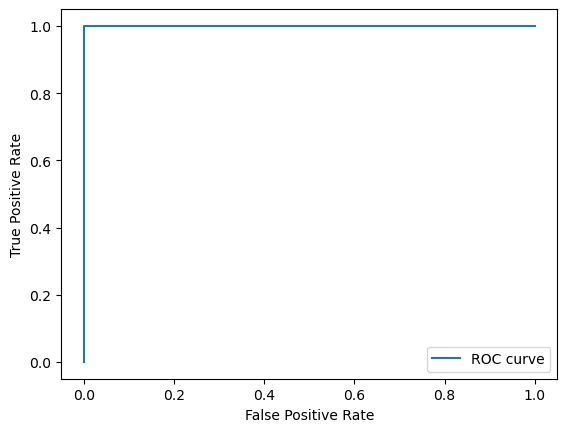

In [22]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


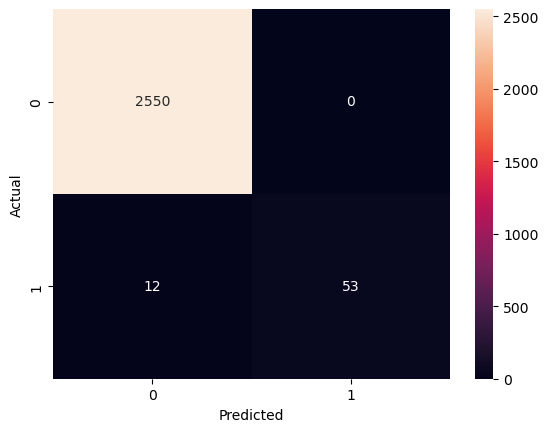

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
